In [82]:
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import cv2 

In [83]:
image_file = json.load(open('../datasets/vg/image_data.json'))
vocab_file = json.load(open('../datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File('../datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [84]:
# load detected results
path = '../checkpoints/iba0.02_s2_inv_prop0.03_power0.5_sum_v3-predcls/'
detected_origin_path = path + 'inference/VG_stanford_filtered_with_attribute_test/'
dir_fmap = path + '/rib/'

In [85]:
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [409]:
def load_fmap(fname): 
    fmap = np.load(fname)
    fmap = np.mean(fmap, axis=1)
    fmap = fmap * (fmap > 0) # ReLU 
    fmap = fmap - fmap.min()  
    fmap /= fmap.max()
    return fmap 
    
def resize_map(fmap, size): 
    return cv2.resize(fmap, size, cv2.INTER_AREA)

def load_mask(fname): 
    masks = np.load(fname)
    return masks 

def load_inds(fname): 
    rel_inds = np.load(fname)
    return rel_inds

def get_mask(masks, rel_inds, query_rel): 
    idx = rel_inds.tolist().index(query_rel)
    return masks[idx, 0, :, :], idx

def get_predicate(rels, query_rel): 
    idx = rels[:, 0:2].tolist().index(query_rel)
    return rels[idx, 2]

def get_union(box1, box2): 
    ubox = [0, 0, 0, 0]
    
    ubox[0] = min(box1[0], box2[0])
    ubox[1] = min(box1[1], box2[1])
    ubox[2] = max(box1[2], box2[2])
    ubox[3] = max(box1[3], box2[3])
    return ubox

In [410]:
def resize_boxes(img, boxes, im_scale=(1024.,)):
    new_boxes = np.copy(boxes)
    h, w = img.shape[0:2]
    if len(im_scale) == 2: 
        scale_w = im_scale[1] / w
        scale_h = im_scale[0] / h 
    else:
        if h > w: 
            scale_h = im_scale[0] / h 
            scale_w = scale_h 
        else:
            scale_w = im_scale[0] / w 
            scale_h = scale_w 
    #ipdb.set_trace()
    new_boxes[:, [0, 2]] = new_boxes[:, [0, 2]] / scale_w
    new_boxes[:, [1, 3]] = new_boxes[:, [1, 3]] / scale_h
    new_boxes = new_boxes.astype(np.int)
    return  new_boxes

In [452]:
# load fmap
def get_fmap(idx):
    # (1, 256, 232, 152)
    fmap = load_fmap(dir_fmap + '{}_fmap.npy'.format(idx))
    fmap = np.swapaxes(fmap, 0,2)
    # (90, 256, 7, 7)
    rib_fmap = load_fmap(dir_fmap + '{}_rib_fmap.npy'.format(idx))
    rib_fmap = np.swapaxes(rib_fmap, 0,2)
    # (90, 1, 15, 15)
    mask = load_mask(dir_fmap + '{}_mask.npy'.format(idx))
    mask = np.swapaxes(mask, 1,3)
    # (90, 2)
    rel_inds = load_inds(dir_fmap + '{}_inds.npy'.format(idx))
    
    return fmap, rib_fmap, mask, rel_inds

In [453]:
idx = 1

In [454]:
fmap, rib_fmap, mask, rel_inds = get_fmap(idx=idx)
fmap.shape

(152, 232, 1)

In [455]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = groundtruth.bbox
    
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    
    #mask = pred_rel_score > thres
    #pred_rel_score = pred_rel_score[mask]
    #pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [456]:
img_path,boxes,labels,gt_rels,pred_rels,pred_rel_score,pred_rel_label= get_info_by_idx(idx=idx,det_input=detected_origin_result)

In [480]:
boxes

tensor([[ 96.6797, 278.8086, 121.0938, 306.1523],
        [332.5195, 123.5352, 498.5352, 229.0039],
        [ 32.2266,  88.8672, 495.6055, 287.1094],
        [103.0273, 183.1055, 198.2422, 275.3906],
        [123.0469, 264.1602, 179.1992, 355.4688],
        [ 87.4023,  50.2930,  94.7266, 310.5469],
        [  2.9297,   0.9766, 497.0703, 125.0000],
        [  0.9766, 207.5195, 235.3516, 373.5352],
        [ 40.0391,  41.5039,  93.2617, 101.5625],
        [ 38.0859, 129.8828, 123.5352, 193.3594],
        [ 97.1680, 161.6211, 193.3594, 358.8867]])

In [479]:
labels

['0-bag',
 '1-bus',
 '2-bus',
 '3-coat',
 '4-pant',
 '5-pole',
 '6-roof',
 '7-sidewalk',
 '8-sign',
 '9-window',
 '10-woman']

In [476]:
gt_rels

[('2-bus', 'under', '6-roof'),
 ('10-woman', 'near', '2-bus'),
 ('9-window', 'on', '2-bus'),
 ('10-woman', 'wearing', '3-coat')]

In [477]:
pred_rels

[('10-woman', 'wearing', '4-pant'),
 ('10-woman', 'wearing', '3-coat'),
 ('8-sign', 'hanging from', '6-roof'),
 ('10-woman', 'walking on', '7-sidewalk'),
 ('9-window', 'on', '2-bus'),
 ('8-sign', 'on', '5-pole'),
 ('10-woman', 'carrying', '0-bag'),
 ('10-woman', 'near', '2-bus'),
 ('3-coat', 'on', '10-woman'),
 ('6-roof', 'over', '2-bus'),
 ('0-bag', 'on', '7-sidewalk'),
 ('5-pole', 'on', '7-sidewalk'),
 ('1-bus', 'near', '2-bus'),
 ('4-pant', 'on', '10-woman'),
 ('2-bus', 'has', '9-window'),
 ('6-roof', 'over', '1-bus'),
 ('8-sign', 'on', '2-bus'),
 ('5-pole', 'holding', '8-sign'),
 ('9-window', 'on', '1-bus'),
 ('8-sign', 'on', '7-sidewalk'),
 ('2-bus', 'has', '6-roof'),
 ('5-pole', 'near', '2-bus'),
 ('6-roof', 'over', '7-sidewalk'),
 ('7-sidewalk', 'near', '2-bus'),
 ('6-roof', 'over', '10-woman'),
 ('1-bus', 'under', '6-roof'),
 ('2-bus', 'near', '1-bus'),
 ('0-bag', 'hanging from', '6-roof'),
 ('8-sign', 'behind', '10-woman'),
 ('0-bag', 'hanging from', '5-pole'),
 ('4-pant', 'un

In [478]:
pred_rel_label

tensor([48, 48, 19, 46, 31, 31, 11, 29, 31, 33, 31, 31, 29, 31, 20, 33, 31, 21,
        31, 31, 20, 29, 33, 29, 33, 43, 29, 19,  8, 19, 43,  8, 43, 29, 31, 43,
        21, 43, 29,  8, 29, 29, 33,  8,  8, 29, 20, 29, 33, 29, 29, 29, 20, 29,
        33, 33, 29, 33, 43, 43, 31, 33, 20, 29, 31, 31, 21, 43,  8,  8, 31, 29,
        22, 33, 29, 43, 31, 31, 19, 29, 33, 31, 11, 20, 31, 11, 33, 29, 20, 33,
        22, 22, 31, 29, 22, 20, 33, 22, 29, 31, 22, 48, 20, 11, 22, 43, 22, 29,
        11, 22])

In [457]:
img = cv2.imread(img_path)

img.shape

(375, 500, 3)

In [458]:
np_boxes = boxes.cpu().numpy().astype(int)
#np_boxes = resize_boxes(img, np_boxes)
np_boxes.max()

498

In [459]:
query_rel = rel_inds

In [460]:
# [96.67969, 123.53516, 498.53516, 306.15234]
union_box = get_union(np_boxes[query_rel[idx][0]], np_boxes[query_rel[idx][1]])

In [461]:
mask, rel_idx = get_mask(mask, rel_inds, list(query_rel[idx]))

In [462]:
mask = resize_map(mask[0], (union_box[2] - union_box[0] + 1, union_box[3] - union_box[1] + 1))

In [463]:
mask.shape

(219, 464)

In [481]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+60, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

def print_list(name, input_list):
    for i, item in enumerate(input_list):
        print(name + ' ' + str(i) + ': ' + str(item))
    
def draw_image(img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels)
        print('*' * 50)
        print_list('gt_rels', gt_rels)
        print('*' * 50)
    print_list('pred_rels', pred_rels[:20])
    print('*' * 50)
    
    return None

In [482]:
if False:
    fmap = resize_map(fmap[0], (img.shape[1], img.shape[0]))
else:
    fmap = resize_map(rib_fmap[0], (img.shape[1], img.shape[0]))
fmap.shape

(375, 500)

In [483]:
fmap[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1].shape

(219, 464)

In [484]:
mask[:,:,None].shape

(219, 464, 1)

In [485]:
heatmap = fmap[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1] * mask
#heatmap = np.uint8(heatmap * 255).mean(2)[:,:,None]
heatmap = np.array(heatmap * 255, dtype = np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_WINTER)

heatmap.shape

(219, 464, 3)

In [486]:
#img = np.copy(img)
overlay = 0.5
img[union_box[1]:union_box[3]+1, union_box[0]:union_box[2]+1, :] += np.uint8(overlay * heatmap)

img.shape

(375, 500, 3)

('10-woman', 'near', '2-bus')
('10-woman', 'wearing', '3-coat')


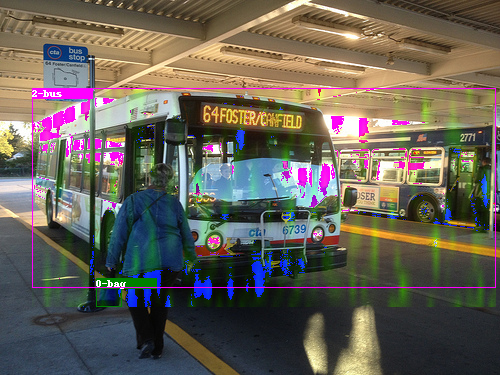

In [487]:
# You may need to convert the color.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)

# For reversing the operation:
#im_np = np.asarray(im_pil)

info = labels[query_rel[idx][0]]
draw_single_box(im_pil, np_boxes[query_rel[idx][0]], draw_info=info, color='green')


info = labels[query_rel[idx][1]]
draw_single_box(im_pil, np_boxes[query_rel[idx][1]], draw_info=info, color='magenta')


print(gt_rels[idx])

print(pred_rels[idx])

im_pil

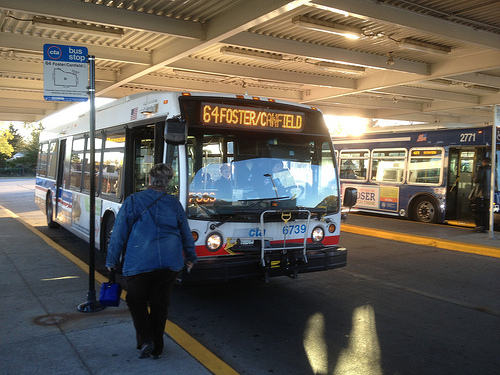

In [488]:
pic = Image.open(img_path)


pic


In [489]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(cand_idx)
        draw_image(*get_info_by_idx(cand_idx, detected_origin_result))

0


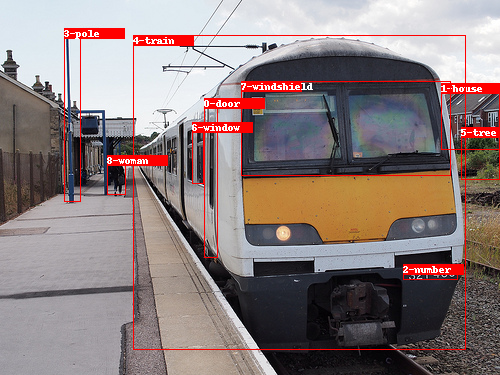

**************************************************
gt_boxes 0: 0-door
gt_boxes 1: 1-house
gt_boxes 2: 2-number
gt_boxes 3: 3-pole
gt_boxes 4: 4-train
gt_boxes 5: 5-tree
gt_boxes 6: 6-window
gt_boxes 7: 7-windshield
gt_boxes 8: 8-woman
**************************************************
gt_rels 0: ('7-windshield', 'on', '4-train')
gt_rels 1: ('6-window', 'on', '4-train')
gt_rels 2: ('4-train', 'has', '6-window')
gt_rels 3: ('1-house', 'near', '4-train')
gt_rels 4: ('5-tree', 'near', '1-house')
**************************************************
pred_rels 0: ('6-window', 'on', '4-train')
pred_rels 1: ('2-number', 'on', '4-train')
pred_rels 2: ('7-windshield', 'on', '4-train')
pred_rels 3: ('0-door', 'on', '4-train')
pred_rels 4: ('4-train', 'has', '7-windshield')
pred_rels 5: ('4-train', 'has', '0-door')
pred_rels 6: ('1-house', 'near', '4-train')
pred_rels 7: ('8-woman', 'near', '4-train')
pred_rels 8: ('4-train', 'has', '6-window')
pred_rels 9: ('4-train', 'has', '2-number')
pred_rels 10

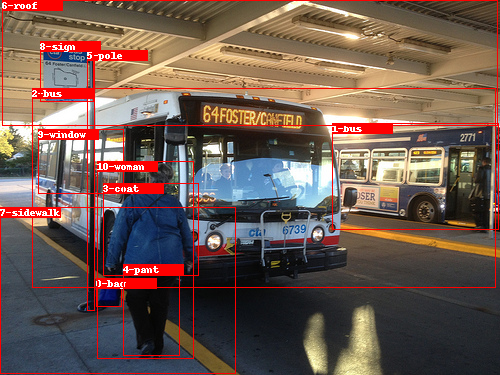

**************************************************
gt_boxes 0: 0-bag
gt_boxes 1: 1-bus
gt_boxes 2: 2-bus
gt_boxes 3: 3-coat
gt_boxes 4: 4-pant
gt_boxes 5: 5-pole
gt_boxes 6: 6-roof
gt_boxes 7: 7-sidewalk
gt_boxes 8: 8-sign
gt_boxes 9: 9-window
gt_boxes 10: 10-woman
**************************************************
gt_rels 0: ('2-bus', 'under', '6-roof')
gt_rels 1: ('10-woman', 'near', '2-bus')
gt_rels 2: ('9-window', 'on', '2-bus')
gt_rels 3: ('10-woman', 'wearing', '3-coat')
**************************************************
pred_rels 0: ('10-woman', 'wearing', '4-pant')
pred_rels 1: ('10-woman', 'wearing', '3-coat')
pred_rels 2: ('8-sign', 'hanging from', '6-roof')
pred_rels 3: ('10-woman', 'walking on', '7-sidewalk')
pred_rels 4: ('9-window', 'on', '2-bus')
pred_rels 5: ('8-sign', 'on', '5-pole')
pred_rels 6: ('10-woman', 'carrying', '0-bag')
pred_rels 7: ('10-woman', 'near', '2-bus')
pred_rels 8: ('3-coat', 'on', '10-woman')
pred_rels 9: ('6-roof', 'over', '2-bus')
pred_rels 10: (

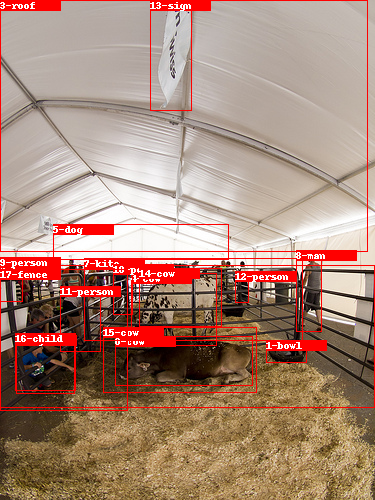

**************************************************
gt_boxes 0: 0-cow
gt_boxes 1: 1-bowl
gt_boxes 2: 2-boy
gt_boxes 3: 3-roof
gt_boxes 4: 4-cow
gt_boxes 5: 5-dog
gt_boxes 6: 6-fence
gt_boxes 7: 7-kite
gt_boxes 8: 8-man
gt_boxes 9: 9-person
gt_boxes 10: 10-person
gt_boxes 11: 11-person
gt_boxes 12: 12-person
gt_boxes 13: 13-sign
gt_boxes 14: 14-cow
gt_boxes 15: 15-cow
gt_boxes 16: 16-child
gt_boxes 17: 17-fence
**************************************************
gt_rels 0: ('13-sign', 'hanging from', '3-roof')
gt_rels 1: ('6-fence', 'near', '0-cow')
**************************************************
pred_rels 0: ('13-sign', 'hanging from', '3-roof')
pred_rels 1: ('0-cow', 'under', '3-roof')
pred_rels 2: ('15-cow', 'under', '3-roof')
pred_rels 3: ('14-cow', 'under', '3-roof')
pred_rels 4: ('10-person', 'watching', '4-cow')
pred_rels 5: ('1-bowl', 'on', '6-fence')
pred_rels 6: ('4-cow', 'under', '3-roof')
pred_rels 7: ('4-cow', 'behind', '6-fence')
pred_rels 8: ('2-boy', 'under', '5-dog')
p

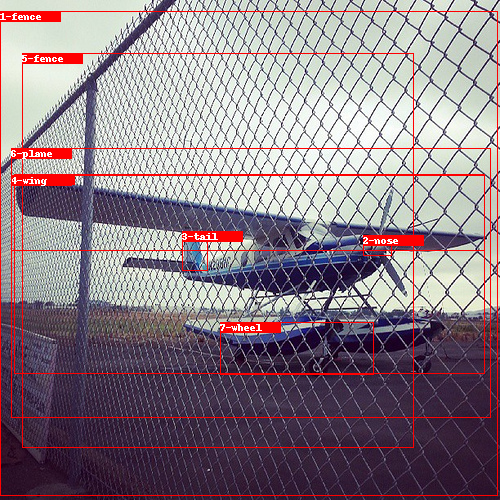

**************************************************
gt_boxes 0: 0-plane
gt_boxes 1: 1-fence
gt_boxes 2: 2-nose
gt_boxes 3: 3-tail
gt_boxes 4: 4-wing
gt_boxes 5: 5-fence
gt_boxes 6: 6-plane
gt_boxes 7: 7-wheel
**************************************************
gt_rels 0: ('4-wing', 'on', '6-plane')
gt_rels 1: ('0-plane', 'has', '3-tail')
gt_rels 2: ('1-fence', 'in front of', '0-plane')
gt_rels 3: ('7-wheel', 'on', '6-plane')
gt_rels 4: ('4-wing', 'on', '0-plane')
**************************************************
pred_rels 0: ('3-tail', 'on', '0-plane')
pred_rels 1: ('4-wing', 'on', '0-plane')
pred_rels 2: ('7-wheel', 'on', '0-plane')
pred_rels 3: ('0-plane', 'has', '3-tail')
pred_rels 4: ('7-wheel', 'on', '6-plane')
pred_rels 5: ('4-wing', 'on', '6-plane')
pred_rels 6: ('0-plane', 'has', '7-wheel')
pred_rels 7: ('0-plane', 'has', '4-wing')
pred_rels 8: ('0-plane', 'has', '2-nose')
pred_rels 9: ('3-tail', 'on', '6-plane')
pred_rels 10: ('2-nose', 'on', '0-plane')
pred_rels 11: ('6-plane'

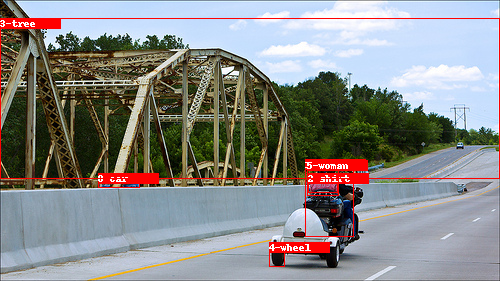

**************************************************
gt_boxes 0: 0-car
gt_boxes 1: 1-people
gt_boxes 2: 2-shirt
gt_boxes 3: 3-tree
gt_boxes 4: 4-wheel
gt_boxes 5: 5-woman
**************************************************
gt_rels 0: ('5-woman', 'wearing', '2-shirt')
gt_rels 1: ('5-woman', 'wearing', '2-shirt')
**************************************************
pred_rels 0: ('5-woman', 'wearing', '2-shirt')
pred_rels 1: ('1-people', 'wearing', '2-shirt')
pred_rels 2: ('2-shirt', 'on', '5-woman')
pred_rels 3: ('0-car', 'under', '3-tree')
pred_rels 4: ('3-tree', 'behind', '1-people')
pred_rels 5: ('3-tree', 'behind', '5-woman')
pred_rels 6: ('3-tree', 'behind', '0-car')
pred_rels 7: ('2-shirt', 'on', '1-people')
pred_rels 8: ('0-car', 'behind', '1-people')
pred_rels 9: ('5-woman', 'behind', '1-people')
pred_rels 10: ('0-car', 'behind', '5-woman')
pred_rels 11: ('1-people', 'near', '3-tree')
pred_rels 12: ('1-people', 'and', '5-woman')
pred_rels 13: ('5-woman', 'near', '3-tree')
pred_rels 14

In [490]:
show_all(start_idx=0, length=5)
#show_selected([119, 967, 713, 5224, 19681, 25371])